# Steamgraph for Twitter
The following notebook measures the frequencies of chosen words linearly through a collection of tweets. The tweets are broken into chunks and the frequency of any number of chosen words are counted within each chunk and then displayed as a steamgraph.

### Before we begin

Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-R.ipynb](textPrep-R.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.

### Let's get started

First, we need to set our working directory (setwd). This is the folder that points to where your data is stored. In our case we have multiple folders that we may want to use at some point, but they are all contained in our Text-Analysis folder, so we will set that as our working directory.

In [1]:
#Set the working directory
setwd("~/Text-Analysis/")

#### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."


These packages are used within the steamgraph script:

- **NLP:** Natural language processing package. Provides basic classes and methods for Natural Language Processing.

- **tm:** this package provides tools (functions) for performing various types of text mining. In this notebook, we will use tm to perform text cleaning in order to have uniform data for analysis. Check out [this link](https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf) for the documentation!

- **ggplot2:** A system for 'declaratively' creating graphics based on "The Grammar of Graphics".

- **ggTimeSeries:** This R package offers novel time series visualisations, is based on ggplot2, and offers geoms and pre-packaged functions for easily creating various charts.

In [2]:
library(NLP)
library(tm)
library(ggplot2)
library(ggTimeSeries)


Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



#### Unzip files
This code points to a zipped file, saves the directory you want it saved in as a variable, then unzips the file and saves the zipped file in the previously specified directory.

In [3]:
#unzip file
#zipF<- "data/twitter/neverAgain.csv.zip"
#outDir<-"data/twitter"
#unzip(zipF,exdir=outDir)

#### Create a corpus
First read the tweets and signify that there is a header row so that the first row of your .csv file is not counted as part of the data. Then convert the column of interest to utf-8. Finally, convert the tweets to a SimpleCorpus object so it can be cleaned using the 'tm' package.

In [4]:
#load file with saved tweets
tweets <- read.csv("data/twitter/parkland/neverAgain.csv", header = T)

corpus <- iconv(tweets$text, to = "utf-8")
corpus <- VCorpus(VectorSource(corpus))

#### Clean the tweets
Next we take steps to clean up the corpus. 

1. We specify that any ASCII format characters are converted to UTF-8 characters. This is necessary since tweets often use special characters, espcially when dealing with emojis. 
2. We convert everything to lower case so that 'Love' and 'love' will count as the same word. 
3. We remove punctuation. 
4. We remove numbers. 
5. We remove any whitespace that is 2 spaces or more. 
6. We create a function that removes urls. 
7. We apply the function to our corpus. 
8. We remove stopwords using the english stopwords list provided by the 'tm' package as well as any others that might detract from our results.

In [5]:
corpus <- tm_map(corpus, content_transformer(function(x) iconv(x, "ASCII", "UTF-8", sub="")))
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, stripWhitespace)
removeURL <- function(x) gsub("http[[:alnum:]]*", "", x)
corpus <- tm_map(corpus, content_transformer(removeURL))
corpus <- tm_map(corpus, removeWords, c(stopwords("SMART"),'amp','rt', 'dont'))

#### Chunk the tweets
In order for the steamgraph to work on a single text, we have to break the text up into separate chunks so that we can count word frequencies in each chunk and display it in the steamgraph. We start by choosing the chunk size. The 'chunks' are by numbers of lines, so in the code below, we are 'chunking' the tweets into segments of 1000 tweets. Then we need to count out how many tweets there are in the collection using 'seq_along' and assigning this process to the variable 'x'. Lastly, we take the tweets, and split it into separate 1000 tweets segments. In our tweets, there are 51 of these segments or 'chunks'. If you have fewer tweets, you may want to decrease this number, if you have more, you may want to increase the number. Adjust it to suit your data.

In [6]:
#Chunk the tweets
chunk.size <- 1000
x <- seq_along(corpus)
text.chunks <- split(corpus, ceiling(x/chunk.size))

#### Convert
Now we convert the separate chunks from a 'list' class object, back into a 'SimpleCorpus' class object.

In [7]:
#Convert the corpus back to a SimpleCorpus or Corpus object
corpus.chunk <- VCorpus(VectorSource(text.chunks))

#### Document Term Matrix
The next step uses the DocumentTermMatrix() function from the tm package. This function creates a matrix where each document is a row and the terms in the text make up the columns, saved here as "dtm." The rest of the matrix consists of the frequencies for each term within each document.

In [8]:
#Create matrix using DocumentTermMatrix function and saving it as "dtm"
dtm <- DocumentTermMatrix(corpus.chunk)

#### Data Frame
Now we turn our document term matrix into a data frame. This is so the steamgraph function can read it later. Next, we go into our new data frame and say we are interested in the 'Terms' column and then say which words are of interest in that column. You can pick as many words as you like, but it should always be separated by a pipe (|), always spell out the data frame's name (DF), then that you are interested in one of the columns ($), the name of that column (Terms), and that you want something that exactly matches (==) your word of interest ('nra'). The next three lines save the separate columns in the data frame as a variable that makes more sense for ploting the steamgraph below.

In [9]:
# Create a data frame
DF <- data.frame(as.table(dtm), stringsAsFactors = FALSE)
df <- DF[ which(DF$Terms=='nra'|DF$Terms=='gop'|DF$Terms=='parkland'|DF$Terms=='trump'), ]
Tweets <- df$Docs
Frequency <- df$Freq
Terms <- df$Terms

#### Plot and print
1. To begin, we need to adjust the width and height of the graph output or we end up getting a square shaped steamgraph which is hard to read.

2. Now we plot our steamgraph and print the visualization. First, we save the plot as 'p' and begin by calling the ggplot function. We want to run the function on the data frame we made above (df) and then we tell ggplot we are adding aesthetic elements (aes). We set the x axis to our 'Tweets' variable above, and the y axis to the 'Frequency' variable. Then we state what we are measuring with 'group=Terms' and then we say we want to color (fill) the graph based on the 'Terms' variable as well.

3. Next, we state that we are making a steamgraph.

4. Then, we want to adjust the angle of the x-tick labels so they are slanted at 45 degrees (angle = 45) and adjust their horizontal positioning so the labels are not so close to the x-tick marks (hjust = 1).

5. Now, we want the label names to be in alphanumeric order (scale_x_discrete(drop=FALSE))

6. This next line simply states what color palette we are using and ggplot2 uses the same palette as the RColorBrewer package. We have chosen 'Dark2', but feel free to adjust to your own aesthetics.

7. Lastly, we are saving a .png of the visualization to be used later. It will be saved in your working directory unless you specificy a different file path. In our case, it will save the .png file in the Text-Analysis folder. Feel free to adjust the width, height, and dpi to suit your needs.

8. Now print!

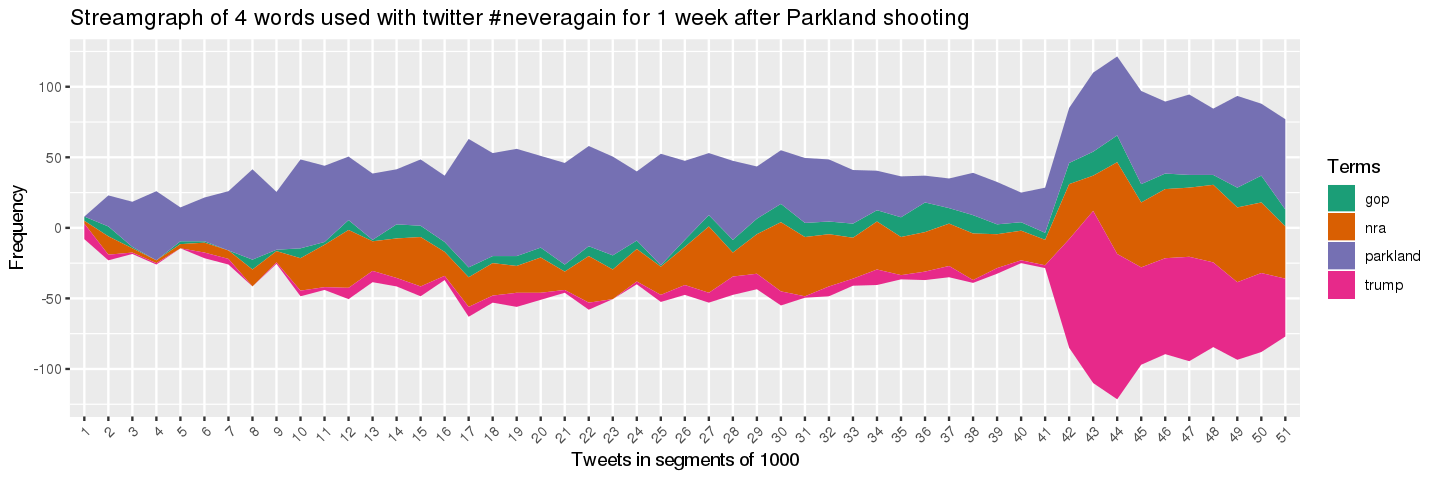

In [10]:
# Plot and print the steamgraph
options(repr.plot.width=12, repr.plot.height=4)
p <- ggplot(df, aes(x=Tweets, y=Frequency, group=Terms, fill=Terms)) +
  stat_steamgraph() +
  theme(axis.text.x=element_text(angle = 45, hjust = 1)) +
  scale_x_discrete(drop=FALSE) +
  scale_fill_brewer(palette = "Dark2") +
  xlab("Tweets in segments of 1000") +
  ggtitle("Streamgraph of 4 words used with twitter #neveragain for 1 week after Parkland shooting")
  ggsave(file="~/Text-Analysis/Output/streamgraphNeverAgainTwitter.png", width=8, height=4, dpi=300)
print(p)

### VOILA!